# Importing libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F


Working with CUDA capabilities.

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())

print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

True
1
0
GeForce RTX 2080 with Max-Q Design


# Loading the train data set

In [3]:
data_dir = '../../Images/june5Night/Positive/'      #This is for the home laptop
# data_dir = '../../../../BottleStoodUp_atNight/Positive/'        #For the work laptop

In [4]:
transform_characteristics = transforms.Compose([transforms.ToTensor(),
                                                transforms.Resize(255),
                                                transforms.CenterCrop(224)])
dataset = datasets.ImageFolder(data_dir, transform=transform_characteristics)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=15, shuffle=True)

We see 20 batches of 15 images each. Becasue we have in total 295 of positive images.

In [5]:
print(len(dataloader))

20


In [6]:
images, labels = next(iter(dataloader))
print("The images are stored in a variable of type: ", type(images))
print("The classes labels are: ", labels)
print(torch.min(images), torch.max(images))

c:\Users\alexj\.conda\envs\tfm_3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


The images are stored in a variable of type:  <class 'torch.Tensor'>
The classes labels are:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor(0.0006) tensor(1.)


# Showing one sample of the training set images

Grabbing only one image of the training set, permuting its shape sizes and converting to numpy to able to display it.

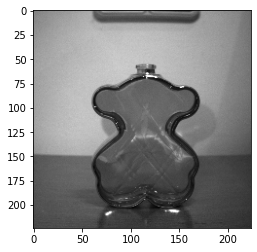

In [7]:
single_img = images[0]
single_img_permuted = single_img.permute(1, 2, 0) 
single_img_numpy = single_img_permuted.detach().numpy()

plt.imshow(single_img_numpy)

# Building the model Autoencoder model

In [8]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # 15, 3, 224, 224.  Batch size, input channels, shape of the image.
        input_channels = 3              # number of channels of the input image
        output_channels = 110           # ~= 224/2. Shape of the input image divided by 2 approximately. 
        kernel_size = 9
        padding_val = 1
        stride_val = 5

        output_channels_layer2 = output_channels*2+5
        output_channels_layer3 = output_channels_layer2*2
        
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size, stride=stride_val, padding=padding_val),         # Dimension rseult: -> 15, 110, 44, 44. Batch size, channels output, output image shape
            nn.ReLU(),
            nn.Conv2d(output_channels, output_channels_layer2, kernel_size, stride=stride_val, padding=padding_val), # Dimension rseult: -> 15, 225, 8, 8
            nn.ReLU(),
            nn.Conv2d(output_channels_layer2, output_channels_layer3, 8) # Dimension rseult: -> 15, 450, 1, 1
        )

        self.fc = nn.Linear(output_channels_layer3, output_channels_layer3)
        self.encoder_tanh = nn.Tanh()
        

        self.decoder_tanh = nn.Tanh()
        self.decoder_fc = nn.Linear(output_channels_layer3, output_channels_layer3)
        # Initial dimension for this part of the model: 15 , 450, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(output_channels_layer3, output_channels_layer2, 8),  # Dimension rseult: -> 15, 225, 8, 8
            nn.ReLU(),
            nn.ConvTranspose2d(output_channels_layer2, output_channels, kernel_size, stride=stride_val, padding=padding_val, output_padding=2), # Dimension rseult: -> 15, 110, 44, 44
            nn.ReLU(),
            nn.ConvTranspose2d(output_channels, input_channels, kernel_size, stride=stride_val, padding=padding_val, output_padding=2), # Dimension rseult: -> 15, 3, 224, 224
            nn.Sigmoid()
        )

        

    def forward(self, x, flag = False):
        if flag:
            print("The FORWARD function is starting")

            print("The ENCODER part is executing")
            encoded = self.encoder(x)
            print("The shape after the entire encoder sequence net is:", encoded.shape)
            # print("The values, after the encoder net part are:", encoded)

            encoded = encoded.view(encoded.size(0), -1)
            print("encoded shape after the encoded.view is: ", encoded.shape)           # Dimension rseult: -> 15, 450
            # print("The values, after the encoded.view part are:", encoded)

            linearCombined = self.fc(encoded)
            print("linearCombined shape after the self.fc is: ", linearCombined.shape)  # Dimension rseult: -> 15, 450
            # print("The values, after the self.fc part are:", linearCombined)

            tanhed = self.encoder_tanh(linearCombined)
            print("tanhed shape after the self.encoder_tanh is: ", tanhed.shape)  # Dimension rseult: -> 15, 450
            # print("The values, after the self.encoder_tanh part are:", tanhed)

            print("The DECODER part is executing")
            dec_tanhed = self.decoder_tanh(tanhed)
            print("dec_tanhed shape after the self.decoder_tanh is: ", dec_tanhed.shape)  # Dimension rseult: -> 15, 450
            dec_linearCombined = self.decoder_fc(dec_tanhed)
            print("dec_linearCombined shape after the self.decoder_fc is: ", dec_linearCombined.shape)  # Dimension rseult: -> 15, 450
            dec_linearCombined = dec_linearCombined.view(-1, dec_linearCombined.size(1), 1, 1)
            print("dec_linearCombined shape after the dec_linearCombined.view is: ", dec_linearCombined.shape)           # Dimension rseult: -> 15, 450, 1, 1
            decoded = self.decoder(dec_linearCombined)
            print("decoded shape is:", decoded.shape)
            print("Finish the FORWARD function")
        else:
            # print("The FORWARD function is starting")

            # print("The ENCODER part is executing")
            encoded = self.encoder(x)
            # print("encoded shape after the entire encoder sequence net is:", encoded.shape)
            encoded = encoded.view(encoded.size(0), -1)
            # print("encoded shape after the encoded.view is: ", encoded.shape)           # Dimension rseult: -> 15, 450
            linearCombined = self.fc(encoded)
            # print("linearCombined shape after the self.fc is: ", linearCombined.shape)  # Dimension rseult: -> 15, 450
            tanhed = self.encoder_tanh(linearCombined)
            # print("tanhed shape after the self.encoder_tanh is: ", tanhed.shape)  # Dimension rseult: -> 15, 450

            # print("The DECODER part is executing")
            dec_tanhed = self.decoder_tanh(tanhed)
            # print("dec_tanhed shape after the self.decoder_tanh is: ", dec_tanhed.shape)  # Dimension rseult: -> 15, 450
            dec_linearCombined = self.decoder_fc(dec_tanhed)
            # print("dec_linearCombined shape after the self.decoder_fc is: ", dec_linearCombined.shape)  # Dimension rseult: -> 15, 450
            dec_linearCombined = dec_linearCombined.view(-1, dec_linearCombined.size(1), 1, 1)
            # print("dec_linearCombined shape after the dec_linearCombined.view is: ", dec_linearCombined.shape)           # Dimension rseult: -> 15, 450, 1, 1
            decoded = self.decoder(dec_linearCombined)
            # print("decoded shape is:", decoded.shape)
            # print("Finish the FORWARD function")
        return decoded
    
 
# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh

Making sure to use the GPU for the trainig stage

In [9]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)

cuda:0


In [10]:
model = Autoencoder()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)
model.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 110, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(110, 225, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(225, 450, kernel_size=(8, 8), stride=(1, 1))
  )
  (fc): Linear(in_features=450, out_features=450, bias=True)
  (encoder_tanh): Tanh()
  (decoder_tanh): Tanh()
  (decoder_fc): Linear(in_features=450, out_features=450, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(450, 225, kernel_size=(8, 8), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(225, 110, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1), output_padding=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(110, 3, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1), output_padding=(2, 2))
    (5): Sigmoid()
  )
)

In [11]:
torch.cuda.empty_cache()

# Training the model

Actually training the model with early stopping and storing the loss function values accross all epochs.

In [12]:
# epochs_toCheck_earlyStopping = 10
# min_diff_earlyStopping = 0.0005
# # Point to training loop video
# num_epochs = 300
# outputs = []
# prev_losses = [float('inf')] * epochs_toCheck_earlyStopping  # Initialize previous losses with infinity
# losses_list = []

# for epoch in range(num_epochs):
#     for (img, _) in dataloader:     # This iterates over the batches of images.
#         img = img.to(device)
#         # Forward pass
#         recon = model(img)          # The entire batch of images is passed to the model
#         loss = criterion(recon, img)

#         # Backward and optimize
#         optimizer.zero_grad()       # Sets the gradients of all optimized torch.Tensors to zero
#         loss.backward()             # The accumulation (or sum) of all the gradients is calculated     
#         optimizer.step()            # can be called once the gradients are computed 

#     print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
#     outputs.append((epoch, img, recon))

#     # Calculate the average loss for the current epoch
#     avg_loss = loss.item()
#     losses_list.append(avg_loss)
#     # Append the current loss to the previous losses list
#     prev_losses.append(avg_loss)
#     prev_losses = prev_losses[1:]  # Keep only the last 5 losses

#     # Check if the last 5 losses are the same (within a tolerance)
#     stop_training = all(abs(loss - prev_loss) < min_diff_earlyStopping for prev_loss in prev_losses)

#     # Break the training loop if the stopping condition is met
#     if stop_training:
#         print('Early stopping triggered. Training stopped.')
#         break

# # open file
# with open('RecErrorLossesList.txt', 'w+') as g:
#     # write elements of list
#     for items in losses_list:
#         g.write('%s\n' %items)
#     print("losses_list written successfully")
# # close the file
# g.close() 

In [13]:
filepath = "models/PytorchCUDA_AutoencoderDS2"

Saving the model

In [14]:
# torch.save(model.state_dict(), filepath)

Loading the model

In [15]:
# For loading the model 
model.load_state_dict(torch.load(filepath))                                         # For home laptop
# model.load_state_dict(torch.load(filepath, map_location=torch.device('cpu')))     # For work laptop
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 110, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(110, 225, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(225, 450, kernel_size=(8, 8), stride=(1, 1))
  )
  (fc): Linear(in_features=450, out_features=450, bias=True)
  (encoder_tanh): Tanh()
  (decoder_tanh): Tanh()
  (decoder_fc): Linear(in_features=450, out_features=450, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(450, 225, kernel_size=(8, 8), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(225, 110, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1), output_padding=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(110, 3, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1), output_padding=(2, 2))
    (5): Sigmoid()
  )
)

The evolution of the loss function accross all epochs.

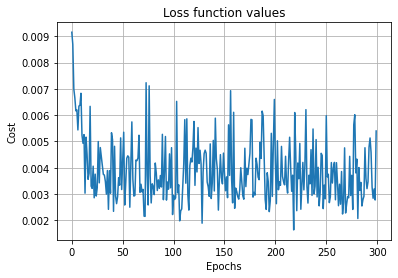

In [110]:
# Load data from the text file
with open("RecErrorLossesList.txt", "r") as file:
    data = [float(line.strip()) for line in file]

# Plot the data
plt.plot(data)
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title("Loss function values")
plt.grid(True)
plt.show()

Once the model has been trained we will show the results:

The below function is used for formatting the image to make it able to be showed.

In [17]:
#Utility functions to un-normalize and display an image
def imshow(img):
    # img = img / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0))) 

# Quantifying the reconstruction error

Performing the computation of the reconstruction error of all the images in the training dataset. Computing the MSE of each image with its reconstructed version.

In [18]:
def mse(image1, image2):
    image_permuted1 = image1.permute(1, 2, 0) 
    img_numpy1 = image_permuted1.detach().cpu().numpy()

    image_permuted2 = image2.permute(1, 2, 0) 
    img_numpy2 = image_permuted2.detach().cpu().numpy()

    squared_diff = np.square(img_numpy1 - img_numpy2)
    mse_value = np.mean(squared_diff)
    return mse_value

In [29]:
result_lst = []

for i in range(len(dataset)):
    X = dataset[i]
    image_in_tensor = X[0]
    image_in_tensor = image_in_tensor[None, :].cuda()   # If using the GPU
    # image_in_tensor = image_in_tensor[None, :]   # If NO GPU
    with torch.no_grad():
        Y = model(image_in_tensor)  # should be same as X
    err = mse(image_in_tensor[0], Y[0])
    result_lst.append( (i,err) )     # idx of data item, err
print(result_lst)

[(0, 0.0011902392), (1, 0.0015425144), (2, 0.0018426902), (3, 0.0018246557), (4, 0.0016426987), (5, 0.0009969941), (6, 0.0009516812), (7, 0.0009319164), (8, 0.00095344736), (9, 0.0009960063), (10, 0.0009589198), (11, 0.0009214274), (12, 0.0011095024), (13, 0.0014926592), (14, 0.0014860997), (15, 0.0009754777), (16, 0.0011544953), (17, 0.001171203), (18, 0.0011606738), (19, 0.0012741457), (20, 0.0011783611), (21, 0.0011988552), (22, 0.001215506), (23, 0.001196128), (24, 0.0013992124), (25, 0.001297489), (26, 0.0010830244), (27, 0.0009494245), (28, 0.0011551635), (29, 0.0011727359), (30, 0.0011604665), (31, 0.0011527205), (32, 0.0009788544), (33, 0.0014058504), (34, 0.004326659), (35, 0.004085678), (36, 0.004059401), (37, 0.0016298996), (38, 0.00094717235), (39, 0.0012552262), (40, 0.0016713653), (41, 0.0017316599), (42, 0.0029487652), (43, 0.0036547869), (44, 0.0040572803), (45, 0.0042084), (46, 0.004322925), (47, 0.0047249757), (48, 0.0048727733), (49, 0.0012733936), (50, 0.0014217305)

In [30]:
result_lst.sort(key=lambda x: x[1], \
reverse=True)  # high error to low
print(result_lst)

[(290, 0.018740717), (291, 0.017981578), (294, 0.017757159), (293, 0.017548753), (289, 0.017308865), (292, 0.017080449), (117, 0.015032683), (274, 0.014309148), (273, 0.013686515), (269, 0.010877512), (270, 0.010719077), (271, 0.010305917), (272, 0.010084152), (280, 0.009784369), (279, 0.009622288), (278, 0.009500938), (275, 0.009279614), (277, 0.009214161), (284, 0.009123655), (276, 0.0090556145), (167, 0.0089956345), (106, 0.008806834), (168, 0.008696695), (166, 0.008523326), (118, 0.008366933), (286, 0.007961585), (165, 0.00794996), (285, 0.007927121), (287, 0.007817855), (282, 0.007326869), (154, 0.007317297), (281, 0.0072958185), (283, 0.0070585557), (119, 0.0069999956), (288, 0.006988008), (107, 0.0068996423), (108, 0.0067463107), (120, 0.006593343), (241, 0.0065212585), (226, 0.0064879945), (112, 0.0064529385), (121, 0.006302328), (110, 0.006291752), (122, 0.0062110284), (187, 0.006161013), (109, 0.006147368), (104, 0.006038411), (213, 0.005954039), (111, 0.005906552), (105, 0.0

Gaphically the distribution of the reconstruction error values is shown below:

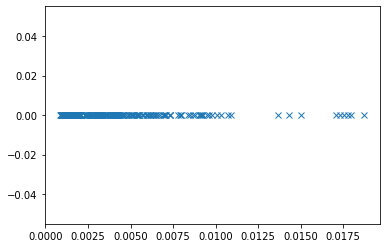

In [31]:
errors_list = []
for i in range(len(result_lst)):
    errors_list.append(result_lst[i][1])  

val = 0. # this is the value where you want the data to appear on the y-axis.
plt.plot(errors_list, np.zeros_like(errors_list) + val, 'x')
plt.show()

In [33]:
na_avg_rcn_error = np.mean(np.array(errors_list))  
na_stdev_rcn_error = np.std(np.array(errors_list)) 
min_prob = np.min(errors_list)
max_prob = np.max(errors_list)
print("THIS IS FOR THE TRAINING (NON-ANOMALY) IMAGES\n")
print("The average of the errors list is: ", na_avg_rcn_error)
print("The standard deviation of the errors list is: ", na_stdev_rcn_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

THIS IS FOR THE TRAINING (NON-ANOMALY) IMAGES

The average of the errors list is:  0.0036735265
The standard deviation of the errors list is:  0.0032327315
The min value of the errors list is:  0.000847716
The max value of the errors list is:  0.018740717


Or displying in a histogram way:

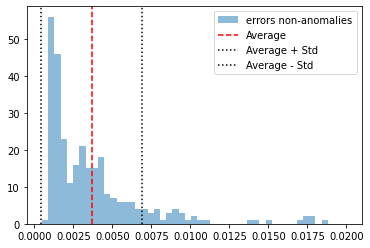

In [32]:
bins = np.linspace(0.0005, 0.02, 50)
plt.hist(errors_list, bins, alpha=0.5, label='errors non-anomalies')
plt.legend(loc='upper right')

# Calculate average and standard deviation
average = np.mean(errors_list)
std = np.std(errors_list)

# Plot average line
plt.axvline(x=average, color='red', linestyle='--', label='Average')

# Plot lines for standard deviation
plt.axvline(x=average + std, color='black', linestyle=':', label='Average + Std')
plt.axvline(x=average - std, color='black', linestyle=':', label='Average - Std')

plt.legend()

plt.show()

# Function to check if an image contains anomalies

Based on the previously found histogram, its average and its standard deviation values, it can be built a function that maps the reconstruction error to a probability value of an image being considered as an anomaly or not.

If the a given reconstruction value is outside the range of the standard deviation sum and subtraction to the average values, shown in the plot above, then that reconstruction error has more than 50% chance to be considered as an anomaly image.

In [34]:
def ranges_mapper(value, leftMin, leftMax, rightMin, rightMax):
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return rightMin + (valueScaled * rightSpan)

In [35]:
def map_error2prob(value):
    # Calculate the mean and standard deviation
    mean = na_avg_rcn_error
    std_dev = na_stdev_rcn_error
    aux_score = value - mean
    prob_score = ranges_mapper(abs(aux_score), 0, std_dev, 0, 50)
    if prob_score<0:
        prob_score = 0
    if prob_score>100:
        prob_score = 100
    return prob_score

Testing a reconstruction error. Verifying that given some reconstruction error, the probability value is the one we expect. 

In [36]:
print(map_error2prob(na_avg_rcn_error + na_stdev_rcn_error))

50.0


In [37]:
def map_error2prob_list(input_list):
    # Calculate the mean and standard deviation
    mean = na_avg_rcn_error
    std_dev = na_stdev_rcn_error
    prob_score_list = []
    for i in range (len(input_list)):
        aux_score = input_list[i] - mean
        prob_score = ranges_mapper(abs(aux_score), 0, std_dev, 0, 50)
        if prob_score<0:
            prob_score = 0
        if prob_score>100:
            prob_score = 100
        prob_score_list.append(prob_score)
    return prob_score_list

# Validating the performance of the model with reconstruction error directly

We will use the validation data set to find the best threshold value for predicting an image as anomaly or non-anomaly.

In [38]:
val_dir = '../../Images/june5Night/Validation'      #This is for the home laptop
# test_dir = '../../../Images/BottleStoodUp_atNight/Evaluation'      #This is for the home laptop
# test_dir = '../../../../BottleStoodUp_atNight/Evaluation'      #This is for the work laptop
transform_characteristics = transforms.Compose([transforms.ToTensor(),
                                                transforms.Resize(255),
                                                transforms.CenterCrop(224)])

dataset_val = datasets.ImageFolder(val_dir, transform=transform_characteristics)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=15, shuffle=True)
classes = ('non-anomaly','anomaly')

In [39]:
y_true = []
recError_lst = []

for i in range(len(dataset_val)):
    X = dataset_val[i]
    image_in_tensor = X[0]
    image_in_tensor = image_in_tensor[None, :].cuda()   # If using the GPU
    # image_in_tensor = image_in_tensor[None, :]   # If NO GPU
    ground_truth = X[1]

    with torch.no_grad():
        Y = model(image_in_tensor)  # should be same as X
    err = mse(image_in_tensor[0], Y[0])
    recError_lst.append(err)     # idx of data item, err
    y_true.append(ground_truth) # Save Truth
print("The reconstruction error list is: ", recError_lst)
print("The ground truth labels are: ", y_true)

The reconstruction error list is:  [0.0015481367, 0.0014046022, 0.0010620528, 0.0014040191, 0.0015632147, 0.0011781814, 0.0016203786, 0.0012217952, 0.008650413, 0.0024773213, 0.00385985, 0.0033745302, 0.0027411385, 0.0038151215, 0.0039057038, 0.0012716958, 0.001574191, 0.013184929, 0.009432612, 0.008315764, 0.013000657, 0.0067787734, 0.02565873, 0.010241725, 0.012717993, 0.0089834, 0.0034508656, 0.01490243, 0.01703589, 0.027866783]
The ground truth labels are:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Let's compute the ROC and AUC score out of directly the reconstruction errors obtained from the images of the validation data set.

In [40]:
from sklearn import metrics
print('AUC = ', metrics.roc_auc_score(y_true, recError_lst))

AUC =  0.92


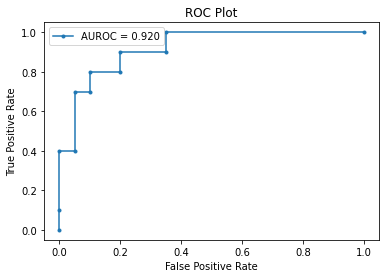

In [41]:
fpr, tpr, thresholds = metrics.roc_curve(y_true, recError_lst)
plt.plot(fpr, tpr, marker='.', label='AUROC = %0.3f' % metrics.roc_auc_score(y_true, recError_lst))
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

In [42]:
print("The fpr is: ", fpr)
print("The tpr is: ", tpr)
print("The thresholds are: ", thresholds)

The fpr is:  [0.   0.   0.   0.05 0.05 0.1  0.1  0.2  0.2  0.35 0.35 1.  ]
The tpr is:  [0.  0.1 0.4 0.4 0.7 0.7 0.8 0.8 0.9 0.9 1.  1. ]
The thresholds are:  [1.0278668  0.02786678 0.01490243 0.01318493 0.01024172 0.00943261
 0.0089834  0.00831576 0.00677877 0.00381512 0.00345087 0.00106205]


The best threshold value for this is: 0.00345087, let's asses this.

In [51]:
def pred_label_onProb(probs_list, prob_threshold):
    pred_based_onProb = []
    for i in range (len(probs_list)):
        if probs_list[i] > prob_threshold:
            prediction = 1                          ## Stands for classifiaction of anomaly bottle
        else:
            prediction = 0
        pred_based_onProb.append(prediction)
    return pred_based_onProb

In [52]:
# from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, SpecificityAtSensitivity
from sklearn.metrics import confusion_matrix

In [57]:
conf_matrix = confusion_matrix(y_true, pred_label_onProb(recError_lst, 0.00345087))
print(conf_matrix)
_tp = conf_matrix[1, 1]
_fn = conf_matrix[1, 0]
_fp = conf_matrix[0, 1]
_tn = conf_matrix[0, 0]
_tpr = _tp/(_tp+_fn)
_fpr = _fp / (_tn + _fp)
print("The FPR values are: ", _fpr)
print("The TPR values are: ", _tpr)
print("Using the threshold = 0.00345087")

[[13  7]
 [ 1  9]]
The FPR values are:  0.35
The TPR values are:  0.9
Using the threshold = 0.00345087


The TPR is almost 1. We could try to find to make the TPR equal to 1, since the current situation would like to avoid all false negatives, that is to predict a bottle as a non-anomaly, being in reality an anomaly.

# Validating the performance of the model with the mapping of the reconstruction error to a probability value

In [58]:
probs_list = map_error2prob_list(recError_lst)
print("The probability list is: ", probs_list)
print("The ground truth labels are: ", y_true)

The probability list is:  [32.87297266385854, 35.09299162604336, 40.3911317935225, 35.10200889108094, 32.63976256648073, 38.5949963109879, 31.755620449774263, 37.92042998237744, 76.97648798557468, 18.50146163240154, 2.881830038094344, 4.624513737500789, 14.421055573145145, 2.19002143112927, 3.591039373758145, 37.14862555850145, 32.46999382619841, 100, 89.07460389574659, 71.80054904484692, 100, 48.02822231101844, 100, 100, 100, 82.12672916140299, 3.4438498075116413, 100, 100, 100]
The ground truth labels are:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [59]:
from sklearn import metrics
print('AUC = ', metrics.roc_auc_score(y_true, probs_list))

AUC =  0.8625


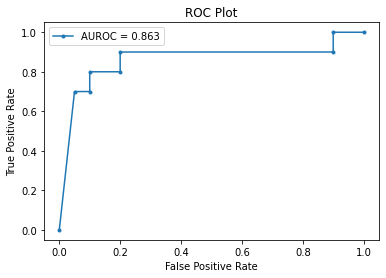

In [67]:
fpr, tpr, thresholds = metrics.roc_curve(y_true, probs_list)
plt.plot(fpr, tpr, marker='.', label='AUROC = %0.3f' % metrics.roc_auc_score(y_true, probs_list))
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

In [68]:
print("The fpr is: ", fpr)
print("The tpr is: ", tpr)
print("The thresholds are: ", thresholds)

The fpr is:  [0.   0.05 0.1  0.1  0.2  0.2  0.9  0.9  1.  ]
The tpr is:  [0.  0.7 0.7 0.8 0.8 0.9 0.9 1.  1. ]
The thresholds are:  [101.         100.          89.0746039   82.12672916  71.80054904
  48.02822231   3.59103937   3.44384981   2.19002143]


The best threshold in terms of FPR and TPR is 48.02822231. Let's asses that.

In [70]:
conf_matrix = confusion_matrix(y_true, pred_label_onProb(probs_list, 48.028222))
print(conf_matrix)
_tp = conf_matrix[1, 1]
_fn = conf_matrix[1, 0]
_fp = conf_matrix[0, 1]
_tn = conf_matrix[0, 0]
_tpr = _tp/(_tp+_fn)
_fpr = _fp / (_tn + _fp)
print("The FPR values are: ", _fpr)
print("The TPR values are: ", _tpr)
print("Using the threshold = 48.02822231")

[[16  4]
 [ 1  9]]
The FPR values are:  0.2
The TPR values are:  0.9
Using the threshold = 48.02822231


# Evaluating the model. With the threhsold value of the direct reconstruction error

In [71]:
test_dir = '../../Images/june5Night/Evaluation'      #This is for the home laptop
# test_dir = '../../../Images/BottleStoodUp_atNight/Evaluation'      #This is for the home laptop
# test_dir = '../../../../BottleStoodUp_atNight/Evaluation'      #This is for the work laptop
transform_characteristics = transforms.Compose([transforms.ToTensor(),
                                                transforms.Resize(255),
                                                transforms.CenterCrop(224)])

dataset_test = datasets.ImageFolder(test_dir, transform=transform_characteristics)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=15, shuffle=True)
classes = ('non-anomaly','anomaly')

In [72]:
y_true = []
recError_lst = []

for i in range(len(dataset_test)):
    X = dataset_test[i]
    image_in_tensor = X[0]
    image_in_tensor = image_in_tensor[None, :].cuda()   # If using the GPU
    # image_in_tensor = image_in_tensor[None, :]   # If NO GPU
    ground_truth = X[1]

    with torch.no_grad():
        Y = model(image_in_tensor)  # should be same as X
    err = mse(image_in_tensor[0], Y[0])
    recError_lst.append(err)     # idx of data item, err
    y_true.append(ground_truth) # Save Truth
print("The reconstruction error list is: ", recError_lst)
print("The ground truth labels are: ", y_true)

c:\Users\alexj\.conda\envs\tfm_3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


The reconstruction error list is:  [0.00181585, 0.0011503359, 0.0012041694, 0.0018692462, 0.0013541131, 0.0009468384, 0.0022694634, 0.0036954717, 0.0061995997, 0.0055393237, 0.017089343, 0.0045088665, 0.0049922233, 0.0018700979, 0.00216539, 0.0037551774, 0.003930835, 0.01094038, 0.017424788, 0.017807288, 0.0058825463, 0.01312497, 0.00516385, 0.0039158748, 0.0094019845, 0.006723547, 0.003367064, 0.005306394, 0.011858265, 0.015948756]
The ground truth labels are:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [73]:
conf_matrix = confusion_matrix(y_true, pred_label_onProb(recError_lst, 0.00345087))
print(conf_matrix)
_tp = conf_matrix[1, 1]
_fn = conf_matrix[1, 0]
_fp = conf_matrix[0, 1]
_tn = conf_matrix[0, 0]
_tpr = _tp/(_tp+_fn)
_fpr = _fp / (_tn + _fp)
print("The FPR values are: ", _fpr)
print("The TPR values are: ", _tpr)
print("Using the threshold =0.00345087")

[[ 9 11]
 [ 1  9]]
The FPR values are:  0.55
The TPR values are:  0.9
Using the threshold =0.00345087


In [76]:
def computePredList(probs_list, threshold_value):
    pred = 0
    pred_list =[]
    for i in range (len(probs_list)):
        if probs_list[i] > threshold_value:              # Working with a threshold of 50%
            pred = 1
        else:
            pred = 0
        pred_list.append(pred)
    return pred_list

In [78]:
y_pred = computePredList(recError_lst, 0.00345087)
print("The groudn truth is: ", y_true)
print("The predicted label is: ", y_pred)

The groudn truth is:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
The predicted label is:  [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1]


# Applying evaluation metrics to these results

## Computing the confusion matrix

In [79]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

In [80]:
conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)

[[ 9 11]
 [ 1  9]]


Text(0.5, 15.0, 'Predicted label')

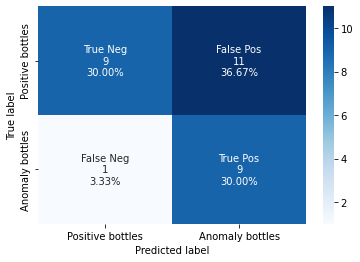

In [81]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                conf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]        #To print the group names as well 

labels = np.asarray(labels).reshape(2,2)
categories = ['Positive bottles', 'Anomaly bottles']
sn.heatmap(conf_matrix, annot=labels, fmt='', xticklabels=categories,yticklabels=categories, cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [82]:
_tp = conf_matrix[1, 1]
_fn = conf_matrix[1, 0]
_fp = conf_matrix[0, 1]
_tn = conf_matrix[0, 0]
_tpr = _tp/(_tp+_fn)
_fpr = _fp / (_tn + _fp)
print("The FPR values are: ", _fpr)
print("The TPR values are: ", _tpr)

The FPR values are:  0.55
The TPR values are:  0.9


## Precision metric

Precision = True positives / (True positives + False positives).

Answers the question: Which proportion of positive predictions is actually right?

In [83]:
precision = _tp/(_tp+_fp)
print("The precision is: ", precision)


The precision is:  0.45


## Recall metric

Recall = TruePositives / (TruePositives + FalseNegatives)

This metric is also called "sensitiviy" and TPR "True Positive Rate". It responds how good is the model at catching YESes?

In [84]:
recall = _tp/(_tp+_fn)
print("The recall is: ", recall)

The recall is:  0.9


## Specificity

Specificity = True negatives / (True negatives + false positives)

The specificity metric is the opposite as sensitivity, it tells us how good is the model at catching NOes. It measures the proportion of actual negatives that are correctly identified as such.

In [85]:
spec = _tn/(_tn+_fp)
print("The specificity is: ", spec)

The specificity is:  0.45


## Accuracy

Accuracy = (True negatives + True positives) / (True positives + True negatives + False positives + False negatives)

In [86]:
acc = (_tn+_tp)/(_tn+_tp +_fp + _fn)
print("The accuracy is: ", acc)

The accuracy is:  0.6


## The ROC curve

In [87]:
from sklearn.metrics import roc_curve, roc_auc_score


Rather than the prediction of each sample (0 or 1 values) we need the probability of the samples to be predicted as an anomaly image. Hence, we compute this probability

In [88]:
auc_score = roc_auc_score(y_true, recError_lst)
print('AUROC = %.3f' % (auc_score))
fpr, tpr, thresholds = roc_curve(y_true, recError_lst)
print("The fpr is: ", fpr)
print("The tpr is: ", tpr)
print("The thresholds are: ", thresholds)

AUROC = 0.730
The fpr is:  [0.   0.05 0.15 0.15 0.2  0.2  0.25 0.25 0.3  0.3  0.45 0.45 0.55 0.55
 1.  ]
The tpr is:  [0.  0.  0.  0.3 0.3 0.5 0.5 0.6 0.6 0.8 0.8 0.9 0.9 1.  1. ]
The thresholds are:  [1.0178072e+00 1.7807288e-02 1.7089343e-02 1.1858265e-02 1.0940380e-02
 6.7235469e-03 6.1995997e-03 5.8825463e-03 5.5393237e-03 5.1638498e-03
 3.9308351e-03 3.9158748e-03 3.6954717e-03 3.3670641e-03 9.4683841e-04]


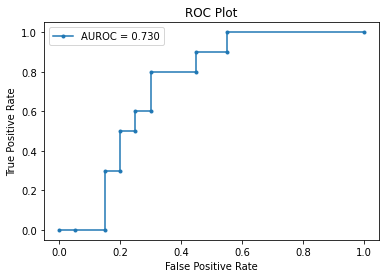

In [89]:
plt.plot(fpr, tpr, marker='.', label='AUROC = %0.3f' % auc_score)
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

# Evaluating the model. With the threhsold value computed from a probability value upon the reconstruction errors

In [91]:
probs_list = map_error2prob_list(recError_lst)
print("The probability list is: ", probs_list)
print("The ground truth labels are: ", y_true)

The probability list is:  [28.73230325724932, 39.02567514971397, 38.1930437994203, 27.906434855733842, 35.873892540128985, 42.173129183989374, 21.71635789496125, 0.33942224395072595, 39.070260915860274, 28.8579057646828, 100, 12.920033856517163, 20.396016385494132, 27.89326187030753, 23.326040536207486, 1.2628780517176161, 3.979739674727372, 100, 100, 100, 34.166460441143045, 100, 23.050527798096233, 3.7483517563068283, 88.60089498516184, 47.17404531506987, 4.73999162806, 25.255227492920874, 100, 100]
The ground truth labels are:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [95]:
conf_matrix = confusion_matrix(y_true, pred_label_onProb(probs_list, 48.028222))
print(conf_matrix)
_tp = conf_matrix[1, 1]
_fn = conf_matrix[1, 0]
_fp = conf_matrix[0, 1]
_tn = conf_matrix[0, 0]
_tpr = _tp/(_tp+_fn)
_fpr = _fp / (_tn + _fp)
print("The FPR values are: ", _fpr)
print("The TPR values are: ", _tpr)
print("Using the threshold = 48.028222")

[[16  4]
 [ 6  4]]
The FPR values are:  0.2
The TPR values are:  0.4
Using the threshold = 48.028222


In [96]:
y_pred = computePredList(probs_list, 48.028222)
print("The groudn truth is: ", y_true)
print("The predicted label is: ", y_pred)

The groudn truth is:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
The predicted label is:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1]


# Applying evaluation metrics to these results

## Computing the confusion matrix

In [97]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

In [98]:
conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)

[[16  4]
 [ 6  4]]


Text(0.5, 15.0, 'Predicted label')

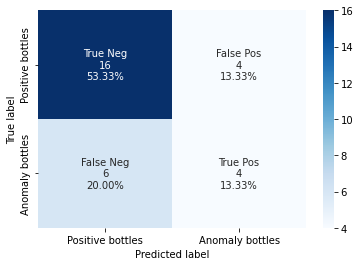

In [100]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                conf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]        #To print the group names as well 

labels = np.asarray(labels).reshape(2,2)
categories = ['Positive bottles', 'Anomaly bottles']
sn.heatmap(conf_matrix, annot=labels, fmt='', xticklabels=categories,yticklabels=categories, cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [101]:
_tp = conf_matrix[1, 1]
_fn = conf_matrix[1, 0]
_fp = conf_matrix[0, 1]
_tn = conf_matrix[0, 0]
_tpr = _tp/(_tp+_fn)
_fpr = _fp / (_tn + _fp)
print("The FPR values are: ", _fpr)
print("The TPR values are: ", _tpr)

The FPR values are:  0.2
The TPR values are:  0.4


## Precision metric

Precision = True positives / (True positives + False positives).

Answers the question: Which proportion of positive predictions is actually right?

In [102]:
precision = _tp/(_tp+_fp)
print("The precision is: ", precision)


The precision is:  0.5


## Recall metric

Recall = TruePositives / (TruePositives + FalseNegatives)

This metric is also called "sensitiviy" and TPR "True Positive Rate". It responds how good is the model at catching YESes?

In [103]:
recall = _tp/(_tp+_fn)
print("The recall is: ", recall)

The recall is:  0.4


## Specificity

Specificity = True negatives / (True negatives + false positives)

The specificity metric is the opposite as sensitivity, it tells us how good is the model at catching NOes. It measures the proportion of actual negatives that are correctly identified as such.

In [104]:
spec = _tn/(_tn+_fp)
print("The specificity is: ", spec)

The specificity is:  0.8


## Accuracy

Accuracy = (True negatives + True positives) / (True positives + True negatives + False positives + False negatives)

In [105]:
acc = (_tn+_tp)/(_tn+_tp +_fp + _fn)
print("The accuracy is: ", acc)

The accuracy is:  0.6666666666666666


## The ROC curve

In [106]:
from sklearn.metrics import roc_curve, roc_auc_score


Rather than the prediction of each sample (0 or 1 values) we need the probability of the samples to be predicted as an anomaly image. Hence, we compute this probability

In [108]:
auc_score = roc_auc_score(y_true, probs_list)
print('AUROC = %.3f' % (auc_score))
fpr, tpr, thresholds = roc_curve(y_true, probs_list)
print("The fpr is: ", fpr)
print("The tpr is: ", tpr)
print("The thresholds are: ", thresholds)

AUROC = 0.575
The fpr is:  [0.   0.2  0.2  0.45 0.45 0.65 0.65 0.7  0.7  0.85 0.85 0.9  0.9  1.  ]
The tpr is:  [0.  0.3 0.5 0.5 0.6 0.6 0.7 0.7 0.8 0.8 0.9 0.9 1.  1. ]
The thresholds are:  [101.         100.          47.17404532  35.87389254  34.16646044
  27.89326187  25.25522749  23.32604054  23.0505278   12.92003386
   4.73999163   3.97973967   3.74835176   0.33942224]


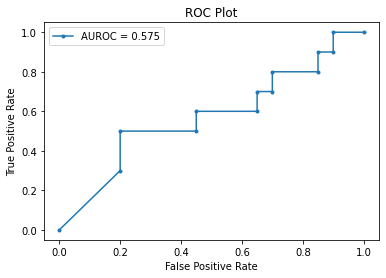

In [109]:
plt.plot(fpr, tpr, marker='.', label='AUROC = %0.3f' % auc_score)
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()